In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim=768, mlp_ratio=4, dropout_rate=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout_rate=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout_rate)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout_rate)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class FeatureFusion(nn.Module):
    def __init__(self, channels, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
            
        self.fusion_conv = nn.Sequential(*layers)
        
    def forward(self, f1, f2):
        fused = torch.cat([f1, f2], dim=1)
        return self.fusion_conv(fused)

class BEiT(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, out_channels=1, 
                 embed_dim=512, num_heads=8, num_layers=6, mlp_ratio=4, 
                 features=[32, 64, 128, 256], dropout_rate=0.15):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout_rate)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout_rate)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        self.fusion1 = FeatureFusion(features[0], dropout_rate, use_dropout=False)
        self.fusion2 = FeatureFusion(features[1], dropout_rate, use_dropout=False)
        self.fusion3 = FeatureFusion(features[2], dropout_rate, use_dropout=False)
        self.fusion4 = FeatureFusion(features[3], dropout_rate=0.1, use_dropout=True)
        
        patch_h = patch_w = img_size // patch_size
        
        self.decode_proj = nn.Linear(embed_dim * 2, features[3] * 2)
        
        self.up4 = nn.ConvTranspose2d(features[3] * 2, features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[3] * 2, features[3], dropout_rate, use_dropout=True)
        
        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2] * 2, features[2], dropout_rate, use_dropout=True)
        
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1] * 2, features[1], dropout_rate, use_dropout=True)
        
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0] * 2, features[0], dropout_rate, use_dropout=True)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        self.enc1 = DoubleConv(in_channels, features[0], dropout_rate, use_dropout=False)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(features[0], features[1], dropout_rate, use_dropout=False)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(features[1], features[2], dropout_rate, use_dropout=False)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(features[2], features[3], dropout_rate, use_dropout=False)
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for blk in self.blocks:
            x = blk(x)
        
        x = self.norm(x)
        return x[:, 1:]
    
    def forward(self, x):
        pre_img = x[:, :3, :, :]
        post_img = x[:, 3:, :, :]
        
        pre_e1 = self.enc1(pre_img)
        pre_p1 = self.pool1(pre_e1)
        
        pre_e2 = self.enc2(pre_p1)
        pre_p2 = self.pool2(pre_e2)
        
        pre_e3 = self.enc3(pre_p2)
        pre_p3 = self.pool3(pre_e3)
        
        pre_e4 = self.enc4(pre_p3)
        
        post_e1 = self.enc1(post_img)
        post_p1 = self.pool1(post_e1)
        
        post_e2 = self.enc2(post_p1)
        post_p2 = self.pool2(post_e2)
        
        post_e3 = self.enc3(post_p2)
        post_p3 = self.pool3(post_e3)
        
        post_e4 = self.enc4(post_p3)
        
        fused_e1 = self.fusion1(pre_e1, post_e1)
        fused_e2 = self.fusion2(pre_e2, post_e2)
        fused_e3 = self.fusion3(pre_e3, post_e3)
        fused_e4 = self.fusion4(pre_e4, post_e4)
        
        pre_transformer_features = self.forward_features(pre_img)
        post_transformer_features = self.forward_features(post_img)
        
        combined_features = torch.cat([pre_transformer_features, post_transformer_features], dim=-1)
        
        B, N, C = combined_features.shape
        patch_h = patch_w = int(N ** 0.5)
        
        combined_features = self.decode_proj(combined_features)
        combined_features = combined_features.transpose(1, 2).reshape(B, -1, patch_h, patch_w)
        
        d4 = self.up4(combined_features)
        d4 = torch.cat([d4, fused_e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, fused_e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, fused_e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, fused_e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.final_conv(d1)
        return out

In [3]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        
        label = (label > 0.5).float()
        
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

In [4]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc), "miou": float(miou)}

In [5]:
def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    if scheduler is not None:
        scheduler.step()
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, "miou": miou,
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, patience=15):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        
        val_metrics = validate(model, val_loader)
        
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_beit_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

In [6]:
def main():
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    model = BEiT(img_size=256, patch_size=16, in_channels=3, out_channels=1, 
                embed_dim=512, num_heads=8, num_layers=6, mlp_ratio=4, 
                features=[32, 64, 128, 256], dropout_rate=0.15).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("Starting BEiT training...")
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader

model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 3972
Validation samples: 331
Test samples: 332


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 25,755,681
Starting BEiT training...

Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:21<00:00,  7.68it/s]


Train Loss: 0.594799 | Train Acc: 0.9175
Val Loss: 0.520004 | Val Acc: 0.9354 | IoU: 0.0228 | Dice: 0.0446 | F1: 0.0446
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.520004

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.28it/s]


Train Loss: 0.478375 | Train Acc: 0.9304
Val Loss: 0.433772 | Val Acc: 0.9432 | IoU: 0.3193 | Dice: 0.4840 | F1: 0.4840
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.433772

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.72it/s]


Train Loss: 0.431886 | Train Acc: 0.9367
Val Loss: 0.440242 | Val Acc: 0.9033 | IoU: 0.3097 | Dice: 0.4730 | F1: 0.4730
Learning Rate: 2.00e-04

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.64it/s]


Train Loss: 0.413746 | Train Acc: 0.9405
Val Loss: 0.394069 | Val Acc: 0.9494 | IoU: 0.3870 | Dice: 0.5581 | F1: 0.5581
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.394069

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.85it/s]


Train Loss: 0.399524 | Train Acc: 0.9436
Val Loss: 0.400559 | Val Acc: 0.9306 | IoU: 0.3673 | Dice: 0.5372 | F1: 0.5372
Learning Rate: 2.00e-04

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.19it/s]


Train Loss: 0.389572 | Train Acc: 0.9474
Val Loss: 0.385351 | Val Acc: 0.9507 | IoU: 0.4093 | Dice: 0.5809 | F1: 0.5809
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.385351

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.75it/s]


Train Loss: 0.382267 | Train Acc: 0.9498
Val Loss: 0.386069 | Val Acc: 0.9489 | IoU: 0.4140 | Dice: 0.5856 | F1: 0.5856
Learning Rate: 2.00e-04

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.98it/s]


Train Loss: 0.374030 | Train Acc: 0.9529
Val Loss: 0.386048 | Val Acc: 0.9523 | IoU: 0.4246 | Dice: 0.5961 | F1: 0.5961
Learning Rate: 2.00e-04

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.21it/s]


Train Loss: 0.364866 | Train Acc: 0.9553
Val Loss: 0.380594 | Val Acc: 0.9453 | IoU: 0.4171 | Dice: 0.5886 | F1: 0.5886
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.380594

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.16it/s]


Train Loss: 0.358494 | Train Acc: 0.9571
Val Loss: 0.371212 | Val Acc: 0.9540 | IoU: 0.4455 | Dice: 0.6164 | F1: 0.6164
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.371212

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.66it/s]


Train Loss: 0.349376 | Train Acc: 0.9596
Val Loss: 0.382123 | Val Acc: 0.9451 | IoU: 0.4361 | Dice: 0.6073 | F1: 0.6073
Learning Rate: 2.00e-04

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.89it/s]


Train Loss: 0.342652 | Train Acc: 0.9614
Val Loss: 0.381935 | Val Acc: 0.9504 | IoU: 0.4263 | Dice: 0.5978 | F1: 0.5978
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.76it/s]


Train Loss: 0.335441 | Train Acc: 0.9633
Val Loss: 0.379188 | Val Acc: 0.9539 | IoU: 0.4567 | Dice: 0.6270 | F1: 0.6270
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.22it/s]


Train Loss: 0.330034 | Train Acc: 0.9647
Val Loss: 0.387679 | Val Acc: 0.9558 | IoU: 0.4374 | Dice: 0.6086 | F1: 0.6086
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.30it/s]


Train Loss: 0.324050 | Train Acc: 0.9662
Val Loss: 0.377481 | Val Acc: 0.9586 | IoU: 0.4590 | Dice: 0.6292 | F1: 0.6292
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.22it/s]


Train Loss: 0.315684 | Train Acc: 0.9682
Val Loss: 0.381332 | Val Acc: 0.9527 | IoU: 0.4545 | Dice: 0.6250 | F1: 0.6250
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.20it/s]


Train Loss: 0.306942 | Train Acc: 0.9705
Val Loss: 0.389633 | Val Acc: 0.9574 | IoU: 0.4364 | Dice: 0.6076 | F1: 0.6076
Learning Rate: 2.00e-04

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.26it/s]


Train Loss: 0.305830 | Train Acc: 0.9704
Val Loss: 0.385671 | Val Acc: 0.9575 | IoU: 0.4534 | Dice: 0.6239 | F1: 0.6239
Learning Rate: 1.40e-04

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 15.02it/s]


Train Loss: 0.287894 | Train Acc: 0.9751
Val Loss: 0.381658 | Val Acc: 0.9604 | IoU: 0.4506 | Dice: 0.6213 | F1: 0.6213
Learning Rate: 1.40e-04

Epoch 20/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.26it/s]

Train Loss: 0.280422 | Train Acc: 0.9768
Val Loss: 0.385082 | Val Acc: 0.9567 | IoU: 0.4667 | Dice: 0.6364 | F1: 0.6364
Learning Rate: 1.40e-04
Early stopping triggered after 20 epochs


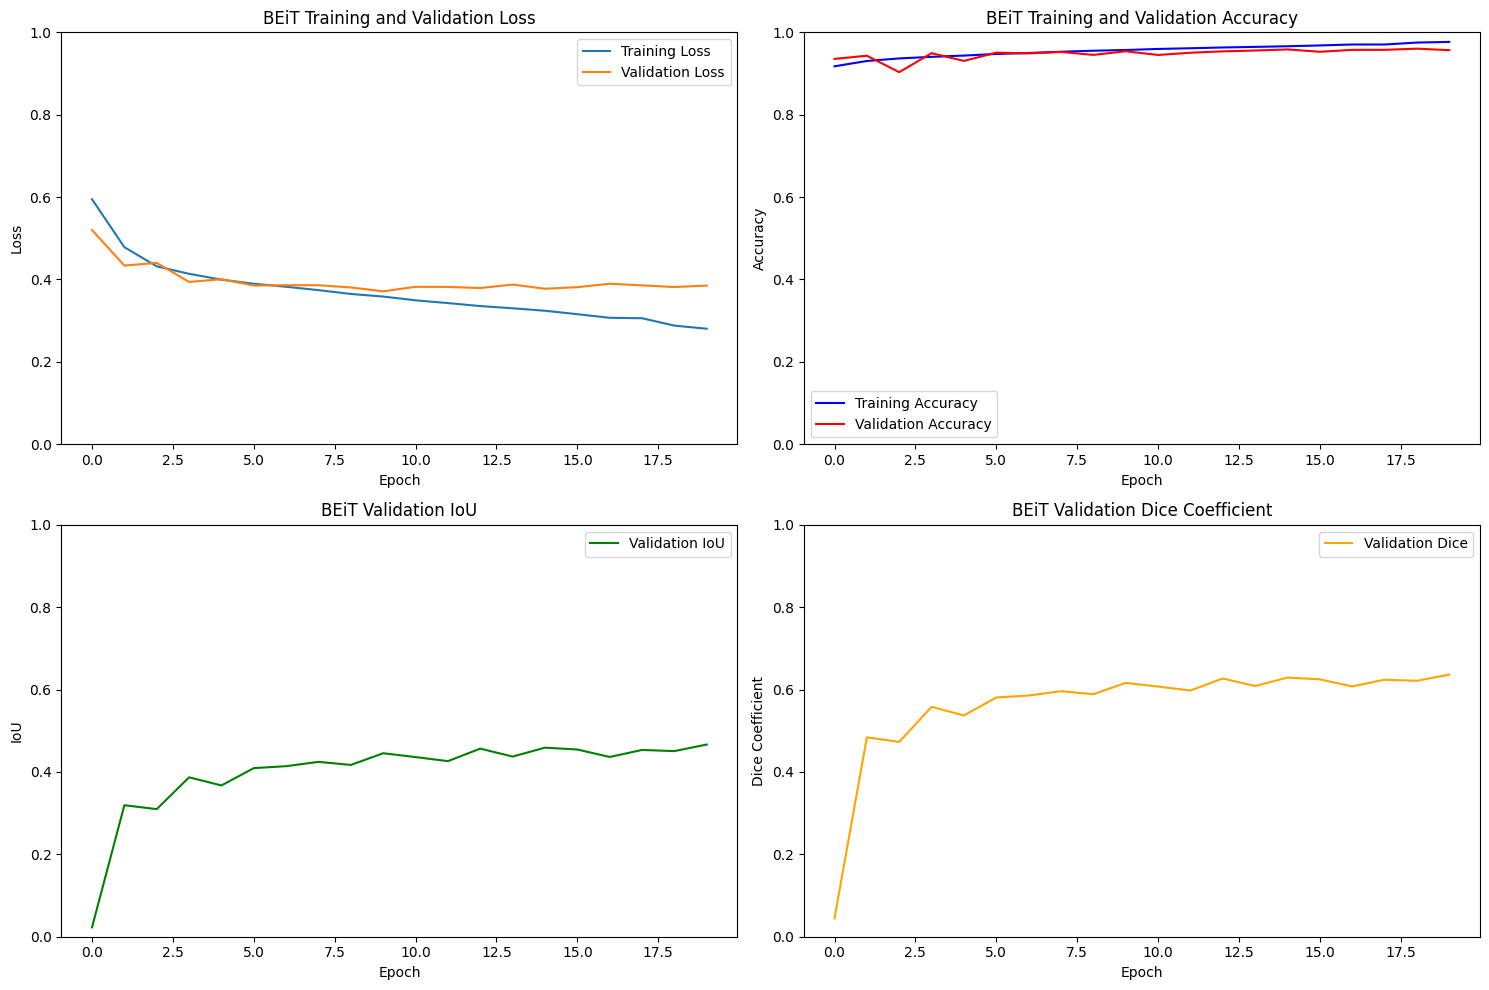

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.set_title('BEiT Training and Validation Loss')

ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_title('BEiT Training and Validation Accuracy')

ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_title('BEiT Validation IoU')

ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_title('BEiT Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('beit_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Loading best BEiT model for test evaluation...

Evaluating BEiT on test set...


Val batch: 100%|██████████| 332/332 [00:19<00:00, 17.04it/s]



BEiT (BIDIRECTIONAL ENCODER REPRESENTATION FROM IMAGE TRANSFORMERS) TEST EVALUATION METRICS
Test set processed with batch_size=1
Loss:            0.372224
IoU:             0.4514
mIoU:            0.7027
Dice Coefficient: 0.6221
Accuracy:        0.9556
Precision:       0.6291
Recall:          0.6152
F1-Score:        0.6221
Confusion matrix (pixel-level):
[[19997648   468593]
 [  497040   794671]]


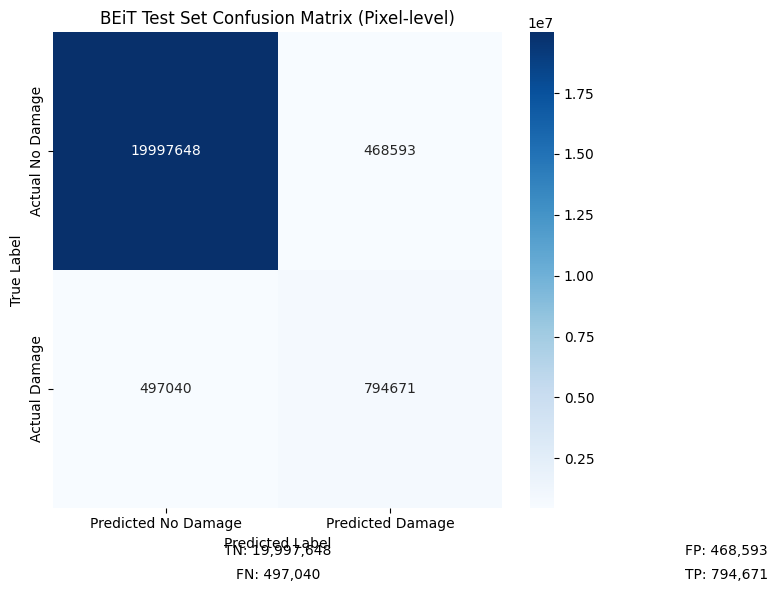

BEiT training and evaluation completed!


In [8]:
print("Loading best BEiT model for test evaluation...")
model.load_state_dict(torch.load('best_beit_earthquake.pth', map_location=device))
model.to(device)

print("\nEvaluating BEiT on test set...")
test_metrics = validate(model, test_loader)

print("\n" + "="*50)
print("BEiT (BIDIRECTIONAL ENCODER REPRESENTATION FROM IMAGE TRANSFORMERS) TEST EVALUATION METRICS")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"mIoU:            {test_metrics['miou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)

plt.figure(figsize=(8, 6))
cm = test_metrics["confusion"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Damage', 'Predicted Damage'],
            yticklabels=['Actual No Damage', 'Actual Damage'])
plt.title('BEiT Test Set Confusion Matrix (Pixel-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.text(0.5, -0.1, f'TN: {cm[0,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]:,}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('beit_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("BEiT training and evaluation completed!")